In [32]:
import psycopg2
import pandas as pd

In [ ]:
from dotenv import load_dotenv
import os

load_dotenv('/home/data/workspace/.env')

username = os.getenv("DLK_reader_PG_USERNAME")
password = os.getenv("DLK_reader_PG_PASSWORD")
host = os.getenv("DLK_reader_PG_HOST")
port = os.getenv("DLK_reader_PG_PORT")
database = os.getenv("DLK_reader_PG_DATABASE")

In [ ]:
conn = psycopg2.connect(
    host=host,
    port=port,
    dbname=database,
    user=username,
    password=password
)

In [ ]:
cur = conn.cursor()
query = """
SELECT id, parameters::json ->> 'input_path' as input_path, deployment_id
FROM bronze.prefect_modint_prod_flow_runs
WHERE state_type = 'FAILED'
  AND created_at < '2025-11-28';
"""

In [4]:
runs_error = pd.read_sql(query, conn)
len(runs_error)

/tmp/ipykernel_243832/3096936146.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  runs_error = pd.read_sql(query, conn)


2007

In [5]:
import requests
import os

API_URL = "https://modint-prefect.sia-service.kr/api"
LOG_DIR = "/home/data/workspace/modint-prefect_logs"
os.makedirs(LOG_DIR, exist_ok=True)

def download_prefect_log(flow_run_id, max_retries=3):
    save_path = os.path.join(LOG_DIR, f"{flow_run_id}.log")

    # 이미 존재하면 스킵
    if os.path.exists(save_path):
        # print(f"[SKIP] {flow_run_id} 이미 존재 → {save_path}")
        return save_path

    url = f"{API_URL}/flow_runs/{flow_run_id}/logs/download"

    for attempt in range(1, max_retries + 1):
        try:
            resp = requests.get(url, timeout=60)

            if resp.status_code == 200:
                with open(save_path, "wb") as f:
                    f.write(resp.content)
                # print(f"[OK] {flow_run_id} 저장 완료 → {save_path}")
                return save_path
            else:
                print(f"[ERROR] {flow_run_id} (시도 {attempt}/{max_retries}) "
                      f"status={resp.status_code}")

        except Exception as e:
            print(f"[EXCEPTION] {flow_run_id} (시도 {attempt}/{max_retries}) → {e}")

        # 다음 시도까지 backoff
        # time.sleep(2 * attempt)

    # print(f"[FAIL] {flow_run_id} 다운로드 실패 (총 {max_retries}회 시도)")
    return None


log_paths = []

for _, row in runs_error.iterrows():
    flow_run_id = row["id"]
    log_path = download_prefect_log(flow_run_id, max_retries=1)
    log_paths.append(log_path)

runs_error["log_path"] = log_paths

[ERROR] fe1b0360-12b3-4674-bd94-b9872dc67e38 (시도 1/1) status=404
[ERROR] fd892774-53d7-48ed-bd20-02354ef7c959 (시도 1/1) status=404
[ERROR] fd63627a-5dba-453e-bcf6-02e9d5c13924 (시도 1/1) status=404
[ERROR] fc450914-7402-4503-9bdf-7d5e90e9dd4b (시도 1/1) status=404
[ERROR] fb571197-4fd1-452b-84b3-d677eeadd6e3 (시도 1/1) status=404
[ERROR] fa453d74-2eff-4c9d-919e-fe870cb19a1c (시도 1/1) status=404
[ERROR] f63b9f11-9423-4783-b531-030721cfe84c (시도 1/1) status=404
[ERROR] f561c735-29fe-4aef-a8b9-9268f961fa40 (시도 1/1) status=404
[ERROR] f4c7b4f8-9de5-4103-ac94-82b946ad68a7 (시도 1/1) status=404
[ERROR] 049581c3-0244-45fe-8507-7461c2011453 (시도 1/1) status=404
[ERROR] f38d9e2d-2d62-4d84-bc52-7f5a96f88686 (시도 1/1) status=404
[ERROR] f25908ac-f46e-4a42-bacb-79043515189b (시도 1/1) status=404
[ERROR] f0da7dc0-71ca-4537-9b75-cc9d8b558da0 (시도 1/1) status=404
[ERROR] f0d8bd8e-338a-443b-9ad4-a392ca522d3e (시도 1/1) status=404
[ERROR] effdec82-c67f-4638-91e7-cbd062974767 (시도 1/1) status=404
[ERROR] ee66c58e-4873-4c7

In [6]:
len(runs_error[runs_error['log_path'].notnull()]), len(runs_error[runs_error['log_path'].isnull()])

(1735, 272)

In [7]:
runs_error[
    (runs_error["input_path"].isnull() | (runs_error["input_path"] == ""))
].shape[0]

121

In [8]:
runs_error[
    runs_error["log_path"].notnull() &
    (runs_error["input_path"].isnull() | (runs_error["input_path"] == ""))
].shape[0]

112

failed
    is_log
        is_input_path: 1623
        not_input_path: 112
    not_log
        is_input_path: 263
        not_input_path: 9

In [9]:
import re
import os

CLASS_PATTERN = re.compile(r'([\w\.]*?(Error|Exception))[\s:"\'\),]')
GENERIC_ERROR_WORDS = ["error", "failed", "exception", "traceback"]

def clean_error_name(err):
    if err is None:
        return None
    name = err.split(".")[-1]
    name = name.strip(' "\':,)')
    name = name.lstrip("n.N,'\"\\ ")
    if name in ["Error", "Exception"]:
        return None
    if "exited with status code: 1" in err:
        name = "ProcessExit_1"
    return name

def extract_main_error_from_log(path):
    if path is None or not os.path.exists(path):
        return None
    with open(path, "r", errors="ignore") as f:
        for line in f:
            if "exited with status code: 1" in line:
                return "ProcessExit_1"
            m = CLASS_PATTERN.search(line)
            if m:
                cleaned = clean_error_name(m.group(1))
                if cleaned:
                    return cleaned
    with open(path, "r", errors="ignore") as f:
        text = f.read().lower()
        if any(w in text for w in GENERIC_ERROR_WORDS):
            return "GenericError"
    return None

def extract_error_cluster_from_log(path, error_class=None):
    if path is None or not os.path.exists(path):
        return None

    with open(path, "r", errors="ignore") as f:
        text = f.read().lower()

    if "cuda out of memory" in text or ("out of memory" in text and "cuda" in text):
        return "CUDA_OOM"
    if "no such file" in text or "not found" in text:
        return "FILE_NOT_FOUND"
    if "is a directory" in text:
        return "IS_A_DIRECTORY"
    if "502" in text or "bad gateway" in text:
        return "HTTP_502"
    if "timeout" in text:
        return "TIMEOUT"
    if "connection" in text or "clientconnectorerror" in text:
        return "CONNECTION_ERROR"
    if "409" in text or "conflict" in text:
        return "HTTP_409"
    if "permission" in text or "denied" in text:
        return "PERMISSION_ERROR"
    if "gdal" in text or "cple_" in text:
        return "GDAL_ERROR"
    if "scheduler" in text:
        return "SCHEDULER_ERROR"
    if "valueerror" in text:
        return "VALUE_ERROR"
    if "typeerror" in text:
        return "TYPE_ERROR"
    if "attributeerror" in text:
        return "ATTRIBUTE_ERROR"
    if "keyerror" in text:
        return "KEY_ERROR"
    if "exit code" in text:
        return "PROCESS_EXIT"
    
    if error_class == "FileNotFoundError":
        return "FILE_NOT_FOUND"
    if error_class == "PrefectHTTPStatusError":
        return "HTTP_ERROR"

    return "OTHER"

In [10]:
errors = []
clusters = []

for _, row in runs_error.iterrows():
    err = extract_main_error_from_log(row["log_path"])
    errors.append(err)
runs_error["error"] = errors

for _, row in runs_error.iterrows():
    clusters.append(extract_error_cluster_from_log(row["log_path"], row["error"]))
runs_error["error_detail"] = clusters

In [11]:
missing = runs_error[runs_error['error'].isnull() & runs_error['log_path'].notnull()]
missing[['id', 'log_path']].head(20)
len(missing)

for _, row in missing.iterrows():
    with open(row['log_path'], 'r', errors='ignore') as f:
        text = f.read().lower()
    if "error" in text or "exception" in text or "traceback" in text:
        print(f"{row['id']},❗ error 문자열은 있음 → 우리의 regex가 놓친 케이스")
    else:
        print(f"{row['id']},⭕ error 문자열 자체가 없음 → 정상 로그 or 실패 정보 미기록")

In [12]:
runs_error['error'].value_counts().sum(), runs_error['error_detail'].value_counts().sum()

(1735, 1735)

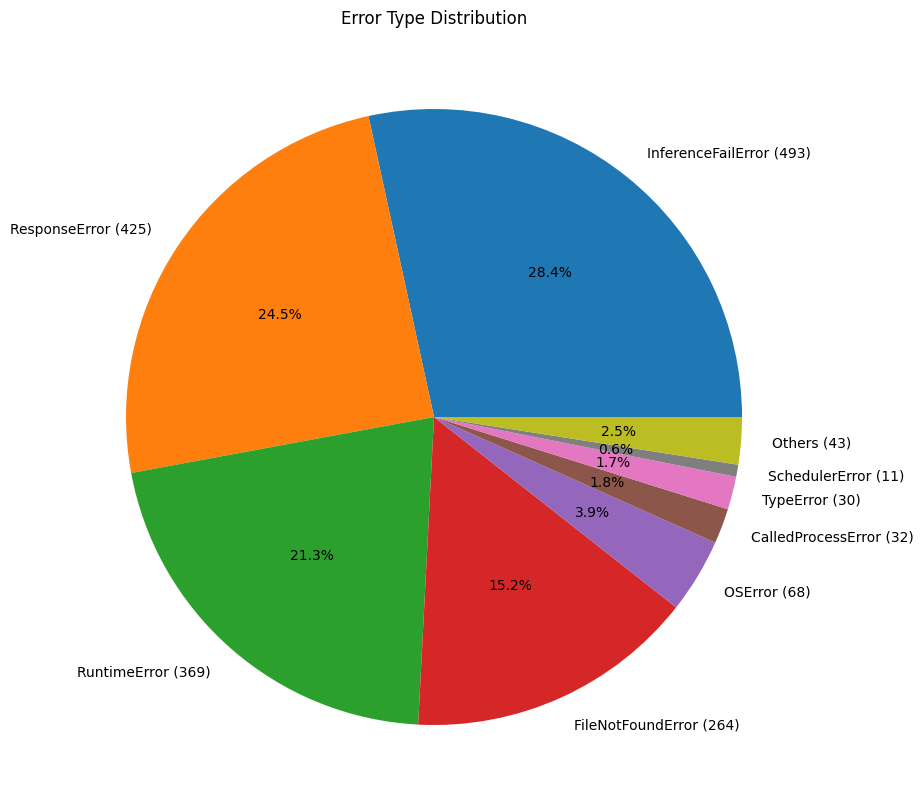

In [13]:
import matplotlib.pyplot as plt

df = runs_error['error'].value_counts().reset_index()
df.columns = ["error", "count"]

threshold = 10
large = df[df["count"] >= threshold]
small = df[df["count"] < threshold]

others_sum = small["count"].sum()
if others_sum > 0:
    large = pd.concat([large, pd.DataFrame({"error": ["Others"], "count": [others_sum]})])

# Labels include both name + count
labels = [f"{e} ({c})" for e,c in zip(large["error"], large["count"])]

plt.figure(figsize=(10,10))
plt.pie(large["count"], labels=labels, autopct="%1.1f%%")
plt.title("Error Type Distribution")
plt.show()

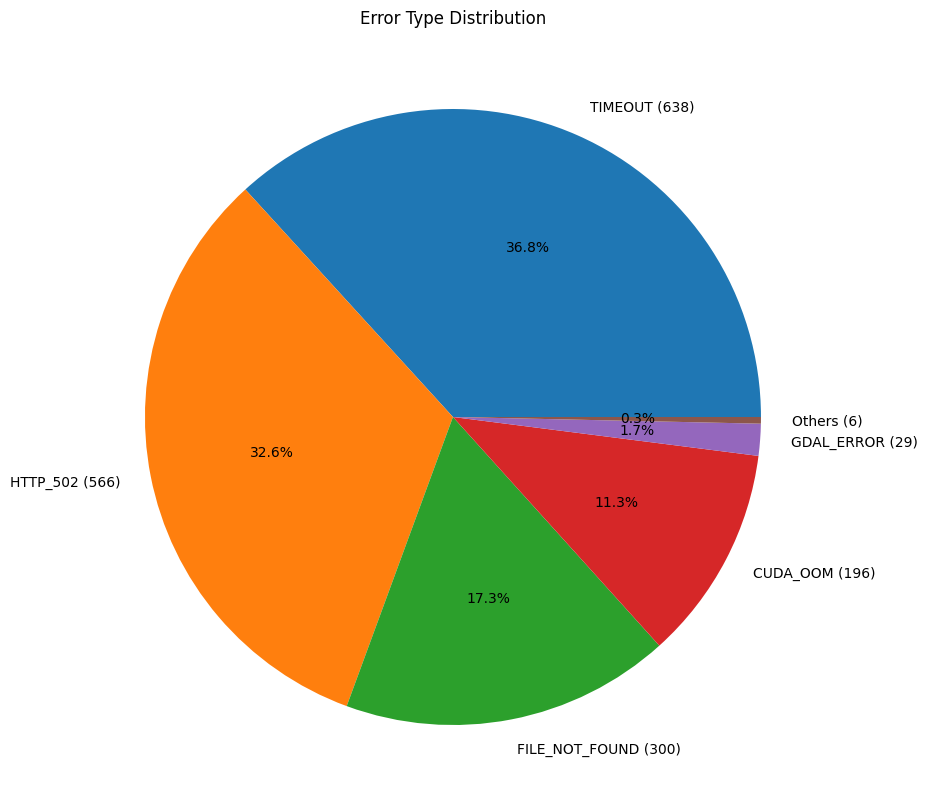

In [14]:
import matplotlib.pyplot as plt

df = runs_error['error_detail'].value_counts().reset_index()
df.columns = ["error", "count"]

threshold = 10
large = df[df["count"] >= threshold]
small = df[df["count"] < threshold]

others_sum = small["count"].sum()
if others_sum > 0:
    large = pd.concat([large, pd.DataFrame({"error": ["Others"], "count": [others_sum]})])

# Labels include both name + count
labels = [f"{e} ({c})" for e,c in zip(large["error"], large["count"])]

plt.figure(figsize=(10,10))
plt.pie(large["count"], labels=labels, autopct="%1.1f%%")
plt.title("Error Type Distribution")
plt.show()

In [15]:
runs_error['error_detail'].value_counts()

error_detail
TIMEOUT           638
HTTP_502          566
FILE_NOT_FOUND    300
CUDA_OOM          196
GDAL_ERROR         29
HTTP_409            3
IS_A_DIRECTORY      2
HTTP_ERROR          1
Name: count, dtype: int64

In [16]:
runs_error[(runs_error["input_path"].isnull() | (runs_error["input_path"] == ""))]["error_detail"].value_counts()

error_detail
TIMEOUT           103
FILE_NOT_FOUND      6
HTTP_502            3
Name: count, dtype: int64

In [17]:
runs_oom = runs_error[runs_error["error_detail"] == "CUDA_OOM"][["id", "input_path"]]

In [25]:
runs_error["deployment_id"].unique()[0:3]

array(['f9a64e74-9c0c-4827-adc1-dc20305b2759', None,
       '105151a8-97f4-405d-858f-50a0327c1e11'], dtype=object)

In [26]:
len(runs_error["deployment_id"].unique())

51

In [ ]:
conn = psycopg2.connect(
    host=host,
    port=port,
    dbname=database,
    user=username,
    password=password
)
cur = conn.cursor()
query = """
SELECT id,
       parameters::json ->> 'input_path' AS input_path
FROM bronze.prefect_modint_prod_flow_runs
WHERE state_type = 'COMPLETED'
  AND parameters::json ->> 'input_path' IS NOT NULL
  AND parameters::json ->> 'input_path' NOT LIKE '%/'
  AND parameters::json ->> 'input_path' NOT LIKE '%plnatscope%'
  AND parameters::json ->> 'input_path' NOT ILIKE '%ext%'
  AND parameters::json ->> 'input_path' NOT ILIKE '%vrt%'
  AND created_at < '2025-11-28'
ORDER BY random()
LIMIT 196;
"""
cur.execute(query)
rows = cur.fetchall()
runs_comp = pd.DataFrame(rows, columns=["id", "input_path"])

In [35]:
from osgeo import gdal

def get_image_size(path):
    try:
        ds = gdal.Open(path)
        return ds.RasterXSize, ds.RasterYSize
    except:
        return None, None

In [36]:
import requests

API_URL = "https://modint-prefect.sia-service.kr/api"

def get_flow_memory(flow_run_id):
    url = f"{API_URL}/flow_runs/{flow_run_id}"
    resp = requests.get(url, timeout=30)
    if resp.status_code != 200:
        return None
    
    data = resp.json()
    mem_str = data["parameters"]["flow_config"].get("memory")
    if mem_str is None:
        return None
    
    # "64Gi" → 64
    return int(mem_str.replace("Gi", ""))

In [37]:
import pandas as pd

def add_features(df):
    mem_list = []
    area_list = []

    for _, row in df.iterrows():
        mem = get_flow_memory(row["id"])
        mem_list.append(mem)

        w, h = get_image_size(row["input_path"])
        if w is None:
            area_list.append(None)
        else:
            area_list.append(w * h)

    df["memory_gi"] = mem_list
    df["area"] = area_list
    return df

runs_oom = add_features(runs_oom)
runs_comp = add_features(runs_comp)

In [ ]:
len(runs_oom["memory_gi"]) - runs_oom["memory_gi"].value_counts().sum(), len(runs_comp["memory_gi"]) - runs_comp["memory_gi"].value_counts().sum()

In [47]:
runs_oom["memory_gi"].value_counts(), runs_comp["memory_gi"].value_counts()

(memory_gi
 64.0    2
 Name: count, dtype: int64,
 memory_gi
 32.0    94
 64.0    85
 Name: count, dtype: int64)

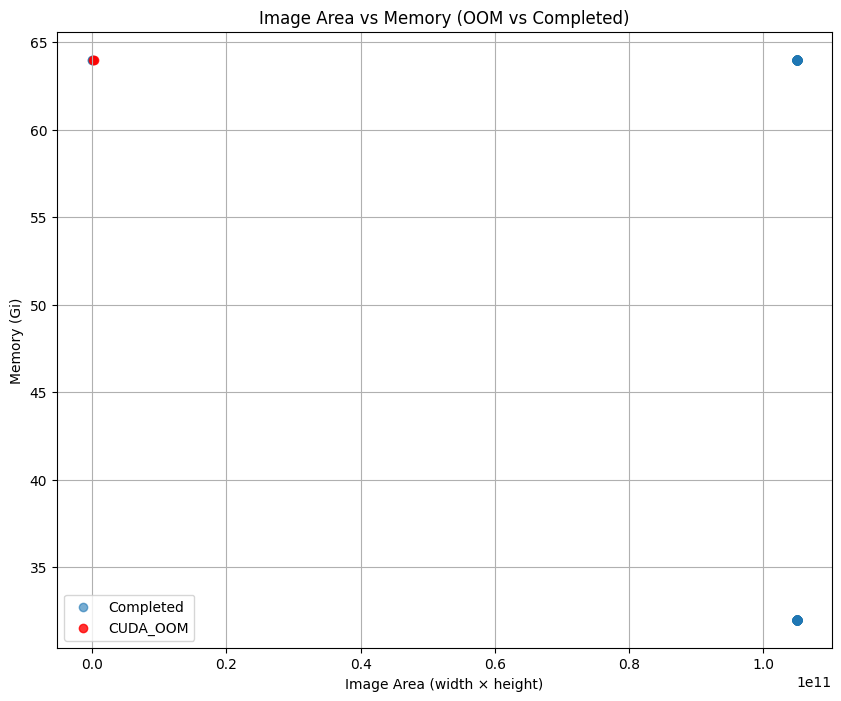

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

plt.scatter(
    runs_comp["area"], runs_comp["memory_gi"],
    label="Completed", alpha=0.6
)

plt.scatter(
    runs_oom["area"], runs_oom["memory_gi"],
    label="CUDA_OOM", alpha=0.8, color="red"
)

plt.xlabel("Image Area (width × height)")
plt.ylabel("Memory (Gi)")
plt.title("Image Area vs Memory (OOM vs Completed)")
plt.legend()
plt.grid(True)
plt.show()

In [49]:
import numpy as np

oom_threshold = np.percentile(runs_oom["area"].dropna(), 10)
oom_threshold

6097637.0

In [54]:
# pip install scikit-learn
from sklearn.linear_model import LogisticRegression

df = pd.concat([
    runs_oom.assign(label=1),
    runs_comp.assign(label=0)
])

df = df.dropna(subset=["area", "memory_gi"])

X = df[["area", "memory_gi"]]
y = df["label"]

clf = LogisticRegression()
clf.fit(X, y)

clf.coef_, clf.intercept_

(array([[-1.10109585e-10,  2.65361381e-16]]), array([4.12668206e-18]))

In [55]:
def recommended_memory(area, coef, intercept):
    a, b = coef[0]
    c = intercept[0]
    # decision boundary: a*area + b*memory + c = 0
    # solve for memory
    return -(a*area + c) / b

coef = clf.coef_
intercept = clf.intercept_

runs_comp["recommended_memory"] = runs_comp["area"].apply(
    lambda area: recommended_memory(area, coef, intercept)
)

In [ ]:
import psycopg2
import pandas as pd

conn = psycopg2.connect(
    host=host,
    port=port,
    dbname=database,
    user=username,
    password=password
)
cur = conn.cursor()
query = """
SELECT id,
       parameters::json ->> 'input_path' AS input_path, state_type, state_name
FROM bronze.prefect_modint_prod_flow_runs
WHERE created_at < '2025-11-28';
"""

runs = pd.read_sql(query, conn)

/tmp/ipykernel_257989/3037612684.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  runs = pd.read_sql(query, conn)


In [2]:
import os

LOG_DIR = "/home/data/workspace/modint-prefect_logs"

def read_log(flow_run_id):
    log_path = os.path.join(LOG_DIR, f"{flow_run_id}.log")
    if os.path.exists(log_path):
        return log_path
    return None

log_paths = []

for _, row in runs.iterrows():
    flow_run_id = row["id"]
    log_path = read_log(flow_run_id)
    log_paths.append(log_path)

runs["log_path"] = log_paths

In [6]:
from osgeo import gdal

def get_image_size(path):
    if not isinstance(path, str):
        return None, None
    if not os.path.exists(path):
        return None, None
    
    try:
        ds = gdal.Open(path)
        if ds is None:
            return None, None
        return ds.RasterXSize, ds.RasterYSize
    except:
        return None, None

import requests

API_URL = "https://modint-prefect.sia-service.kr/api"

def get_flow_resources(flow_run_id):
    url = f"{API_URL}/flow_runs/{flow_run_id}"
    try:
        resp = requests.get(url, timeout=30)
        if resp.status_code != 200:
            return None, None, None
        
        data = resp.json()

        params = data.get("parameters", {})
        flow_config = params.get("flow_config", {})

        mem_str = flow_config.get("memory")
        if mem_str is None:
            memory = None
        else:
            memory = int(mem_str.replace("Gi", ""))

        deployment_name = flow_config.get("prefect_deployment_name")
        work_pool_name = data.get("work_pool_name")

        return memory, deployment_name, work_pool_name

    except Exception:
        return None, None, None

In [7]:
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

def process_row(row):
    memory, deployment_name, work_pool_name = get_flow_resources(row["id"])
    w, h = get_image_size(row["input_path"])
    area = w * h if w and h else None
    return (row["id"], memory, deployment_name, work_pool_name, area)

def parallel_extract(df, workers=8):
    ids = []
    mems = []; deploys = []; work_pools =[];
    areas = []

    rows = [row for _, row in df.iterrows()]

    with ProcessPoolExecutor(max_workers=workers) as ex:
        for result in tqdm(ex.map(process_row, rows), total=len(rows)):
            id_, mem, deploy, work_pool, area = result
            ids.append(id_)
            mems.append(mem)
            deploys.append(deploy)
            work_pools.append(work_pool)
            areas.append(area)

    df["memory_gi"] = mems
    df["deployment_name"] = deploys
    df["work_pool_name"] = work_pools
    df["area"] = areas
    return df

In [8]:
runs = parallel_extract(runs, workers=12)

 22%|██▏       | 9560/42519 [03:40<10:52, 50.55it/s]ERROR 4: `/nas/Dataset/ARGOS/02SuperX2/40000_global_monthly_2025_04_mosaic/' not recognized as a supported file format.
ERROR 4: `/nas/k8s/dev/data/modint-prefect/temp/chain/groovy-mouse/0' not recognized as a supported file format.
 23%|██▎       | 9721/42519 [03:43<09:11, 59.42it/s]ERROR 4: `/nas/Dataset/ARGOS/02SuperX2/40000_global_monthly_2025_01_mosaic/' not recognized as a supported file format.
ERROR 4: `/nas/Projects/C-BIZ01A/SkymapGlobalPH/PH_Navy/EO/Maxar/PHNAVY_POC' not recognized as a supported file format.
 23%|██▎       | 9731/42519 [03:44<10:45, 50.80it/s]ERROR 4: `/nas/Projects/C-BIZ01A/PacGeo/Satellogic/50cm' not recognized as a supported file format.
ERROR 4: `/nas/Dataset/ARGOS/02SuperX2/40000_global_monthly_2025_02_mosaic/' not recognized as a supported file format.
 23%|██▎       | 9763/42519 [03:45<15:22, 35.49it/s]ERROR 4: `/nas/k8s/dev/research/minkisong/ID_team/ardet2recls/02_ori_docker_out_ardet/results/Basem

In [9]:
runs.to_csv("/home/data/workspace/modint_prefect_failed_runs_with_logs.csv", index=False)

In [10]:
import re
import os

CLASS_PATTERN = re.compile(r'([\w\.]*?(Error|Exception))[\s:"\'\),]')
GENERIC_ERROR_WORDS = ["error", "failed", "exception", "traceback"]

def clean_error_name(err):
    if err is None:
        return None
    name = err.split(".")[-1]
    name = name.strip(' "\':,)')
    name = name.lstrip("n.N,'\"\\ ")
    if name in ["Error", "Exception"]:
        return None
    if "exited with status code: 1" in err:
        name = "ProcessExit_1"
    return name

def extract_main_error_from_log(path):
    if path is None or not os.path.exists(path):
        return None
    with open(path, "r", errors="ignore") as f:
        for line in f:
            if "exited with status code: 1" in line:
                return "ProcessExit_1"
            m = CLASS_PATTERN.search(line)
            if m:
                cleaned = clean_error_name(m.group(1))
                if cleaned:
                    return cleaned
    with open(path, "r", errors="ignore") as f:
        text = f.read().lower()
        if any(w in text for w in GENERIC_ERROR_WORDS):
            return "GenericError"
    return None

def extract_error_cluster_from_log(path, error_class=None):
    if path is None or not os.path.exists(path):
        return None

    with open(path, "r", errors="ignore") as f:
        text = f.read().lower()

    if "cuda out of memory" in text or ("out of memory" in text and "cuda" in text):
        return "CUDA_OOM"
    if "no such file" in text or "not found" in text:
        return "FILE_NOT_FOUND"
    if "is a directory" in text:
        return "IS_A_DIRECTORY"
    if "502" in text or "bad gateway" in text:
        return "HTTP_502"
    if "timeout" in text:
        return "TIMEOUT"
    if "connection" in text or "clientconnectorerror" in text:
        return "CONNECTION_ERROR"
    if "409" in text or "conflict" in text:
        return "HTTP_409"
    if "permission" in text or "denied" in text:
        return "PERMISSION_ERROR"
    if "gdal" in text or "cple_" in text:
        return "GDAL_ERROR"
    if "scheduler" in text:
        return "SCHEDULER_ERROR"
    if "valueerror" in text:
        return "VALUE_ERROR"
    if "typeerror" in text:
        return "TYPE_ERROR"
    if "attributeerror" in text:
        return "ATTRIBUTE_ERROR"
    if "keyerror" in text:
        return "KEY_ERROR"
    if "exit code" in text:
        return "PROCESS_EXIT"
    
    if error_class == "FileNotFoundError":
        return "FILE_NOT_FOUND"
    if error_class == "PrefectHTTPStatusError":
        return "HTTP_ERROR"

    return "OTHER"

In [44]:
errors = []
clusters = []

for _, row in runs.iterrows():
    err = extract_main_error_from_log(row["log_path"])
    errors.append(err)
runs["error"] = errors

for _, row in runs.iterrows():
    clusters.append(extract_error_cluster_from_log(row["log_path"], row["error"]))
runs["error_cluster"] = clusters

In [51]:
runs.to_csv("/home/data/workspace/modint_prefect_failed_runs_with_logs_errors.csv", index=False)

In [1]:
import pandas as pd
runs = pd.read_csv("/home/data/workspace/modint_prefect_failed_runs_with_logs_errors.csv")

In [2]:
def convert_memory_label(x):
    if pd.isna(x):
        return "None"
    return f"{int(x)}Gi"

runs["memory"] = runs["memory_gi"].apply(convert_memory_label)

In [3]:
stages = [
    "memory",
    "state_type",
    "state_name",
    "error_cluster",
    "error",
    "deployment_name"
]

def encode_none(df):
    df = df.copy()
    for col in stages:
        df[col] = df[col].apply(lambda x: f"None:{col}" if pd.isna(x) else x)
    return df

In [4]:
runs_encoded = encode_none(runs)
failed = runs_encoded[runs_encoded["state_type"] == "FAILED"]
others = runs_encoded[runs_encoded["state_type"] != "FAILED"]

In [5]:
g1 = failed.groupby(["memory", "state_type"]).size().reset_index(name="count")
g2 = failed.groupby(["state_type", "state_name"]).size().reset_index(name="count")
g3 = failed.groupby(["state_name", "error_cluster"]).size().reset_index(name="count")
g4 = failed.groupby(["error_cluster", "error"]).size().reset_index(name="count")

failed_links = []
for _, row in g1.iterrows():
    failed_links.append([row["memory"], row["state_type"], row["count"]])

for _, row in g2.iterrows():
    failed_links.append([row["state_type"], row["state_name"], row["count"]])

for _, row in g3.iterrows():
    failed_links.append([row["state_name"], row["error_cluster"], row["count"]])

for _, row in g4.iterrows():
    failed_links.append([row["error_cluster"], row["error"], row["count"]])

In [6]:
s1 = others.groupby(["memory", "state_type"]).size().reset_index(name="count")
s2 = others.groupby(["state_type", "state_name"]).size().reset_index(name="count")
s3 = others.groupby(["state_name", "deployment_name"]).size().reset_index(name="count")


others_links = []
for _, row in s1.iterrows():
    others_links.append([row["memory"], row["state_type"], row["count"]])

for _, row in s2.iterrows():
    others_links.append([row["state_type"], row["state_name"], row["count"]])

for _, row in s3.iterrows():
    others_links.append([row["state_name"], row["deployment_name"], row["count"]])

In [7]:
all_links = failed_links + others_links
links_df = pd.DataFrame(all_links, columns=["source", "target", "count"])
links_df = links_df.fillna("NoError")

In [8]:
node_labels = pd.unique(links_df[["source", "target"]].values.ravel()).tolist()

# desired_order = ["FAILED", "COMPLETED"]
# current_state_nodes = [x for x in node_labels if x in desired_order]
# extra_state_nodes = [
#     x for x in node_labels
#     if x not in desired_order and x.startswith("state_type:")]

# final_state_nodes = desired_order + extra_state_nodes

# other_nodes = [x for x in node_labels if x not in final_state_nodes]
# node_labels_ordered = final_state_nodes + other_nodes

# node_index = {name: i for i, name in enumerate(node_labels_ordered)}

node_index = {name: i for i, name in enumerate(node_labels)}

sources = links_df["source"].map(node_index)
targets = links_df["target"].map(node_index)
values  = links_df["count"]

In [11]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,
        thickness=20,
        label=node_labels,
        line=dict(color="black", width=0.5),
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
    )
)])

fig.update_layout(
    title_text=(
        "Flow Run Alluvial Diagram<br>"
        "<sup>FAILED: memory → state_type → state_name → error_cluster → error<br>"
        "OTHERS: memory → state_type → state_name → deployment_name</sup>"
    ),
    font_size=12,
    height=900
)

fig.show()

In [12]:
import datetime
ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
fig.write_html(f"/home/data/workspace/sankey_{ts}.html")

In [14]:
runs.columns

Index(['id', 'input_path', 'state_type', 'state_name', 'log_path', 'memory_gi',
       'deployment_name', 'work_pool_name', 'area', 'error', 'error_cluster',
       'memory'],
      dtype='object')

In [21]:
failed = runs[runs["state_type"] == "FAILED"].copy()
succ = runs[runs["state_type"] == "COMPLETED"].copy()
failed["memory_gi"].value_counts(dropna=False), succ["memory_gi"].value_counts(dropna=False)

(memory_gi
 64.0     1054
 NaN       611
 32.0      303
 256.0      21
 512.0       9
 128.0       9
 Name: count, dtype: int64,
 memory_gi
 64.0     16312
 NaN      13866
 32.0      9426
 256.0       49
 128.0       12
 512.0        5
 16.0         1
 Name: count, dtype: int64)

In [19]:
failed_mean = failed["memory_gi"].mean()
succ_mean = succ["memory_gi"].mean()

failed_median = failed["memory_gi"].median()
succ_median = succ["memory_gi"].median()

print(f"Failed Memory - Mean: {failed_mean}, Median: {failed_median}")
print(f"Success Memory - Mean: {succ_mean}, Median: {succ_median}")

Failed Memory - Mean: 63.24355300859599, Median: 64.0
Success Memory - Mean: 52.790389459407095, Median: 64.0


In [20]:
failed_nan_rate = failed["memory_gi"].isna().mean()
succ_nan_rate   = succ["memory_gi"].isna().mean()
print(f"Failed Memory NaN Rate: {failed_nan_rate:.2%}")
print(f"Success Memory NaN Rate: {succ_nan_rate:.2%}")

Failed Memory NaN Rate: 30.44%
Success Memory NaN Rate: 34.95%


In [22]:
failed_corr = failed[["memory_gi", "area"]].corr()
succ_corr = succ[["memory_gi", "area"]].corr()
print("Failed Correlation:\n", failed_corr)
print("Success Correlation:\n", succ_corr)

Failed Correlation:
            memory_gi      area
memory_gi   1.000000 -0.368669
area       -0.368669  1.000000
Success Correlation:
            memory_gi      area
memory_gi   1.000000 -0.478712
area       -0.478712  1.000000


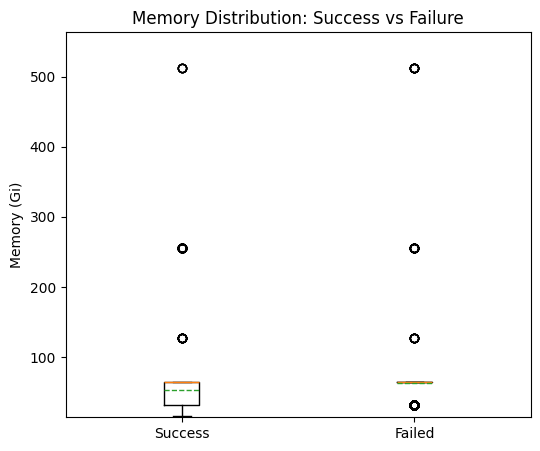

In [39]:
import matplotlib.pyplot as plt

succ_valid = succ["memory_gi"].dropna()
failed_valid = failed["memory_gi"].dropna()

plt.figure(figsize=(6,5))
plt.boxplot(
    [succ_valid, failed_valid],
    labels=["Success", "Failed"],
    showmeans=True,
    meanline=True
)

plt.ylim(min(runs["memory_gi"].dropna()) * 0.9,
         max(runs["memory_gi"].dropna()) * 1.1)

plt.ylabel("Memory (Gi)")
plt.title("Memory Distribution: Success vs Failure")
plt.show()

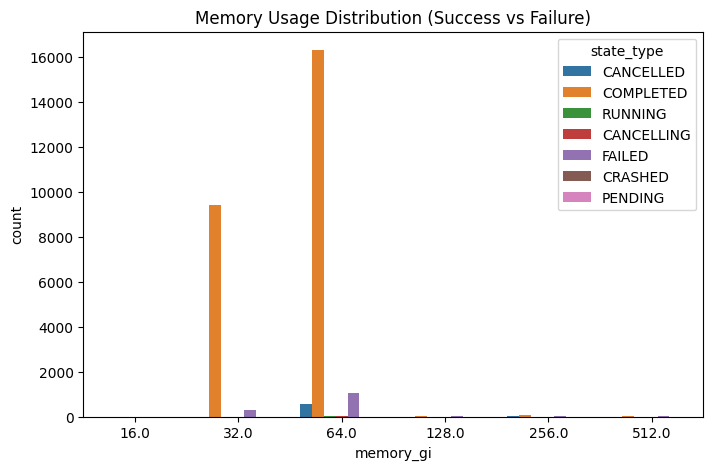

In [42]:
mem_dist = runs.groupby(["state_type", "memory_gi"]).size().reset_index(name="count")

# pip install seaborn
import seaborn as sns
plt.figure(figsize=(8,5))
sns.barplot(data=mem_dist, x="memory_gi", y="count", hue="state_type")
plt.title("Memory Usage Distribution (Success vs Failure)")
plt.show()

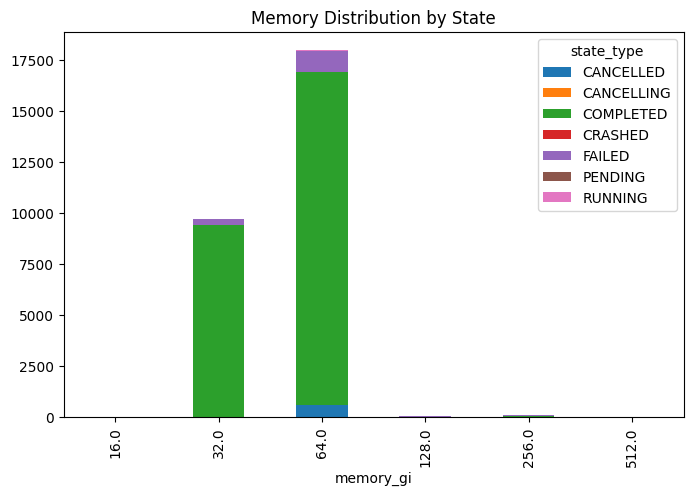

In [43]:
pivot = mem_dist.pivot(index="memory_gi", columns="state_type", values="count").fillna(0)
pivot.plot(kind="bar", stacked=True, figsize=(8,5))
plt.title("Memory Distribution by State")
plt.show()

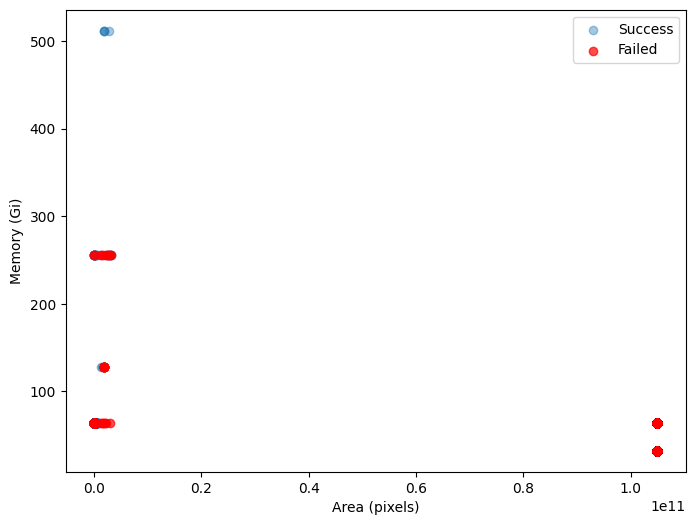

In [24]:
plt.figure(figsize=(8,6))
plt.scatter(succ["area"], succ["memory_gi"], alpha=0.4, label="Success")
plt.scatter(failed["area"], failed["memory_gi"], alpha=0.7, label="Failed", color="red")
plt.xlabel("Area (pixels)")
plt.ylabel("Memory (Gi)")
plt.legend()
plt.show()

In [25]:
risk = (
    failed["memory_gi"].value_counts() /
    (failed["memory_gi"].value_counts() + succ["memory_gi"].value_counts())
)
risk

memory_gi
16.0          NaN
32.0     0.031144
64.0     0.060693
128.0    0.428571
256.0    0.300000
512.0    0.642857
Name: count, dtype: float64

0        (268435456.0, 104958263296.0]
1                                  NaN
2        (268435456.0, 104958263296.0]
3                                  NaN
4                                  NaN
                     ...              
42514    (268435456.0, 104958263296.0]
42515       (124760592.0, 268435456.0]
42516    (268435456.0, 104958263296.0]
42517    (268435456.0, 104958263296.0]
42518       (124760592.0, 268435456.0]
Name: area_bin, Length: 42519, dtype: category
Categories (3, interval[float64, right]): [(1934.999, 124760592.0] < (124760592.0, 268435456.0] < (268435456.0, 104958263296.0]]

In [82]:
import numpy as np
# area 기반 성공률 분석
runs["area_bin"] = pd.qcut(runs["area"], q=20, duplicates="drop")
runs["area_bin"] = runs["area_bin"].astype("object").replace({np.nan: None})
rate_area = (
    runs.groupby(["area_bin", "memory_gi"])["state_type"]
        .apply(lambda x: (x=="COMPLETED").mean())
        .reset_index(name="success_rate")
)
rate_area

,area_bin,memory_gi,success_rate
0,"(1934.999, 124760592.0]",64.0,0.595556
1,"(1934.999, 124760592.0]",256.0,0.727273
2,"(124760592.0, 268435456.0]",64.0,0.920890
3,"(124760592.0, 268435456.0]",256.0,0.857143
4,"(268435456.0, 104958263296.0]",32.0,0.968756
5,"(268435456.0, 104958263296.0]",64.0,0.911253
6,"(268435456.0, 104958263296.0]",128.0,0.250000
7,"(268435456.0, 104958263296.0]",256.0,0.428571
8,"(268435456.0, 104958263296.0]",512.0,0.571429


In [83]:
rate_dep = (
    runs.groupby(["deployment_name", "memory_gi"])["state_type"]
        .apply(lambda x: (x=="COMPLETED").mean())
        .reset_index(name="success_rate")
)
rate_dep

,deployment_name,memory_gi,success_rate
0,BHC-PSS-Change-Detection-Building,32.0,0.952212
1,BHC-PSS-Change-Detection-Road,32.0,0.989024
2,BHC-PSS-Segmentation-Building,64.0,0.922184
3,BHC-PSS-Segmentation-Building,256.0,0.333333
4,BHC-PSS-Segmentation-Road,64.0,0.915885
5,BHC-PSS-Segmentation-Road,256.0,0.000000
6,EO-Classification-Airplane,16.0,0.333333
7,EO-Classification-Airplane,64.0,0.625000
8,EO-Classification-Ship,64.0,0.894737
9,EO-Detection-Aircraft,64.0,0.000000


In [84]:
rate_pool = (
    runs.groupby(["work_pool_name", "memory_gi"])["state_type"]
        .apply(lambda x: (x=="COMPLETED").mean())
        .reset_index(name="success_rate")
)
rate_pool

,work_pool_name,memory_gi,success_rate
0,modint-prefect-workpool,32.0,0.670616
1,modint-prefect-workpool,64.0,0.896582
2,modint-prefect-workpool,128.0,0.461538
3,modint-prefect-workpool,256.0,0.533333
4,modint-prefect-workpool,512.0,0.277778
5,modint-prefect-workpool-2,16.0,0.333333
6,modint-prefect-workpool-2,32.0,0.982273
7,modint-prefect-workpool-2,64.0,0.812500


In [86]:
rate_area_dep = (
    runs.groupby(["deployment_name", "area_bin", "memory_gi"])
        .state_type.apply(lambda x: (x=="COMPLETED").mean())
        .reset_index(name="success_rate")
)
rate_area_dep

,deployment_name,area_bin,memory_gi,success_rate
0,BHC-PSS-Change-Detection-Building,"(268435456.0, 104958263296.0]",32.0,0.952212
1,BHC-PSS-Change-Detection-Road,"(268435456.0, 104958263296.0]",32.0,0.989024
2,BHC-PSS-Segmentation-Building,"(124760592.0, 268435456.0]",64.0,0.922822
3,BHC-PSS-Segmentation-Building,"(124760592.0, 268435456.0]",256.0,1.000000
4,BHC-PSS-Segmentation-Building,"(268435456.0, 104958263296.0]",64.0,0.921547
5,BHC-PSS-Segmentation-Road,"(124760592.0, 268435456.0]",64.0,0.916391
6,BHC-PSS-Segmentation-Road,"(268435456.0, 104958263296.0]",64.0,0.915380
7,EO-Detection-Ship,"(1934.999, 124760592.0]",64.0,0.818182
8,EO-Detection-Ship,"(124760592.0, 268435456.0]",64.0,0.933333
9,EO-Detection-TEL,"(1934.999, 124760592.0]",64.0,1.000000


In [87]:
rate_area_dep_pool = (
 runs.groupby(["deployment_name", "memory_gi", "area_bin", "work_pool_name"])
 ["state_type"]
 .apply(lambda x: (x=="COMPLETED").mean())
 .reset_index(name="success_rate")
)
rate_area_dep_pool

,deployment_name,memory_gi,area_bin,work_pool_name,success_rate
0,BHC-PSS-Change-Detection-Building,32.0,"(268435456.0, 104958263296.0]",modint-prefect-workpool,0.689560
1,BHC-PSS-Change-Detection-Building,32.0,"(268435456.0, 104958263296.0]",modint-prefect-workpool-2,0.971360
2,BHC-PSS-Change-Detection-Road,32.0,"(268435456.0, 104958263296.0]",modint-prefect-workpool,0.551724
3,BHC-PSS-Change-Detection-Road,32.0,"(268435456.0, 104958263296.0]",modint-prefect-workpool-2,0.994902
4,BHC-PSS-Segmentation-Building,64.0,"(268435456.0, 104958263296.0]",modint-prefect-workpool,0.921547
5,BHC-PSS-Segmentation-Building,256.0,"(124760592.0, 268435456.0]",modint-prefect-workpool,1.000000
6,BHC-PSS-Segmentation-Road,64.0,"(268435456.0, 104958263296.0]",modint-prefect-workpool,0.915380
7,EO-Detection-Ship,64.0,"(1934.999, 124760592.0]",modint-prefect-workpool-2,0.818182
8,EO-Detection-Ship,64.0,"(124760592.0, 268435456.0]",modint-prefect-workpool-2,0.933333
9,EO-Detection-TEL,64.0,"(1934.999, 124760592.0]",modint-prefect-workpool-2,1.000000


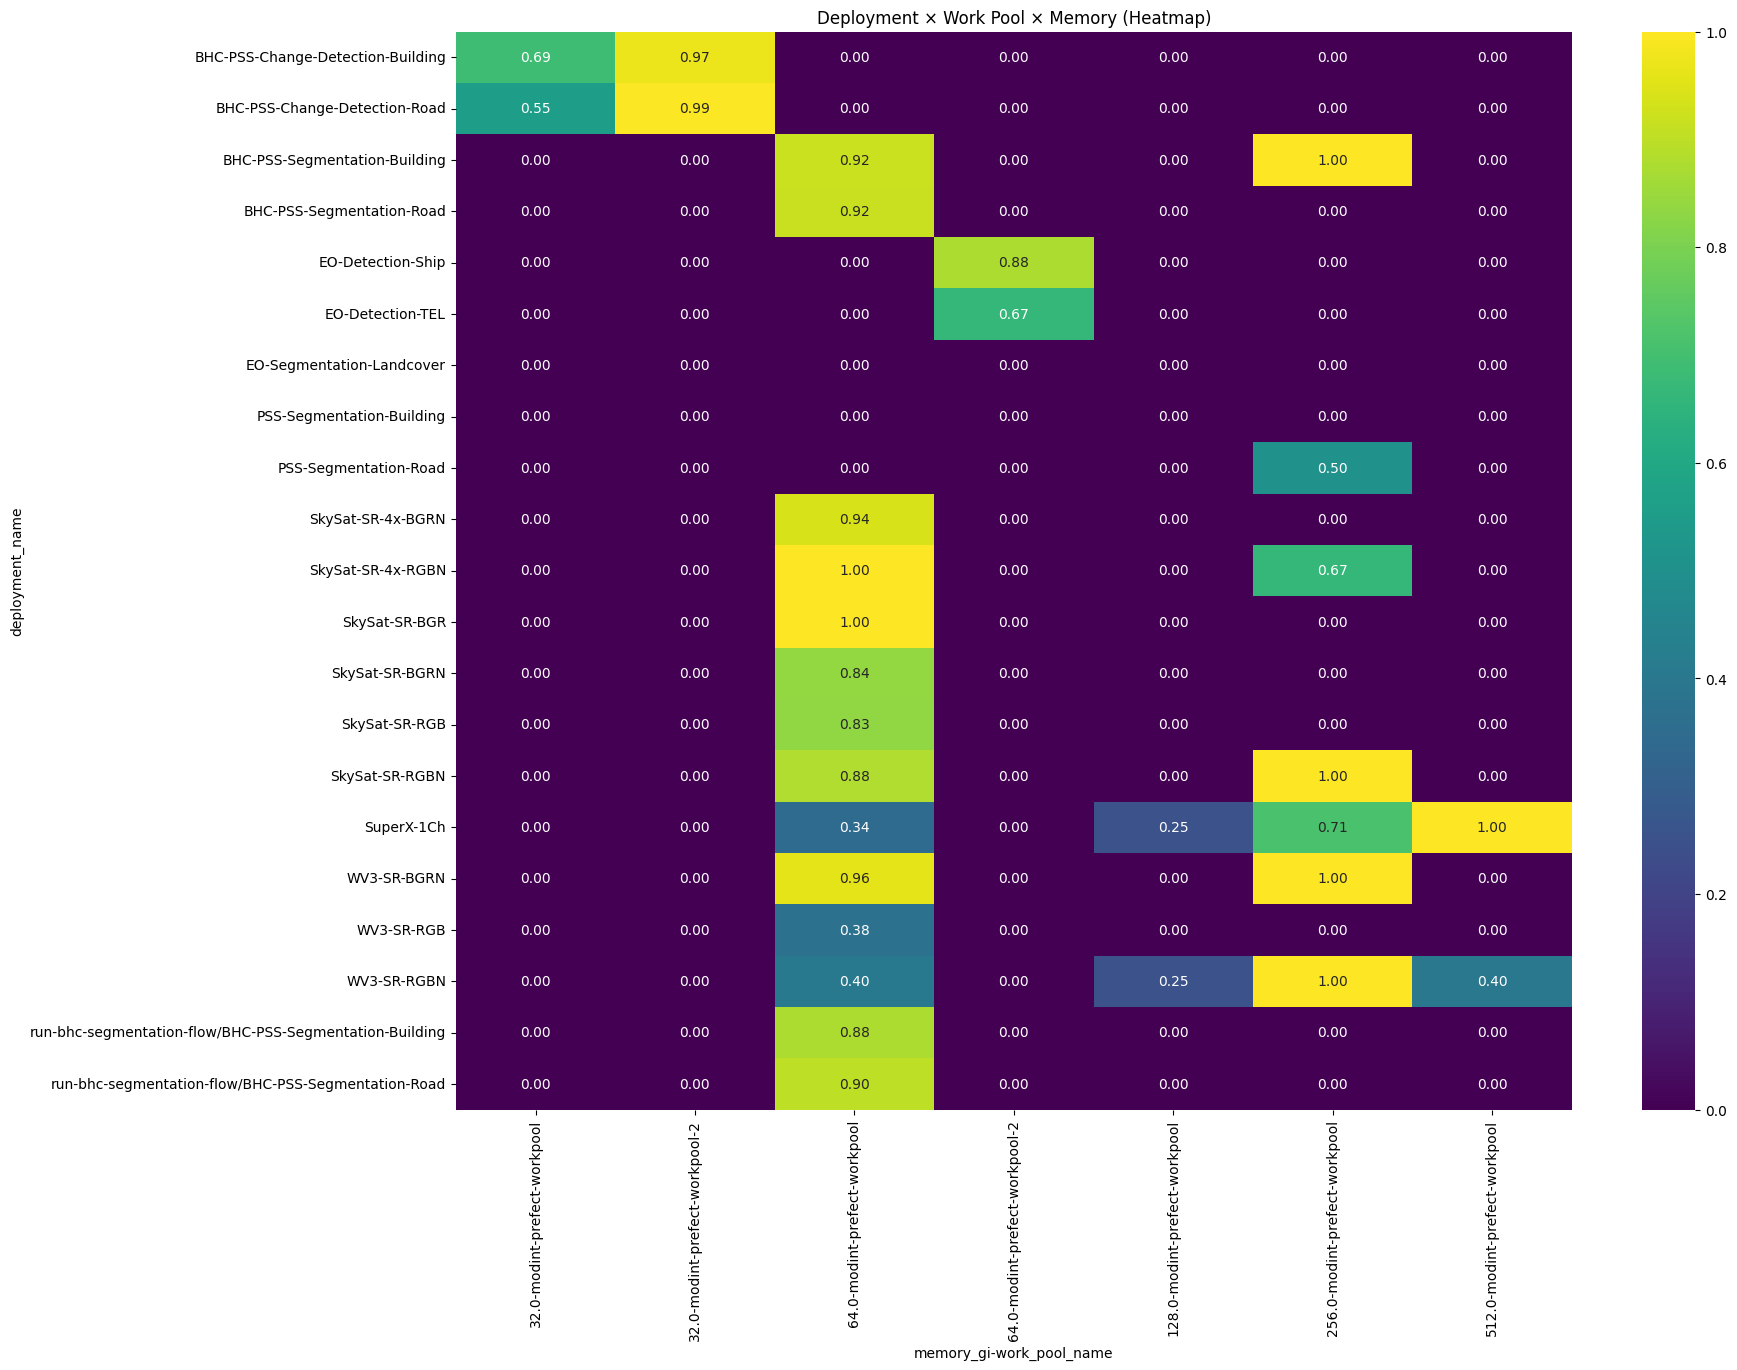

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = rate_area_dep_pool.copy()

pivot = df.pivot_table(
    values="success_rate",
    index="deployment_name",
    columns=["memory_gi","work_pool_name"],
    aggfunc="mean"
).fillna(0)

plt.figure(figsize=(18, 14))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".2f",
    cmap="viridis"
)

plt.title("Deployment × Work Pool × Memory (Heatmap)")
plt.show()

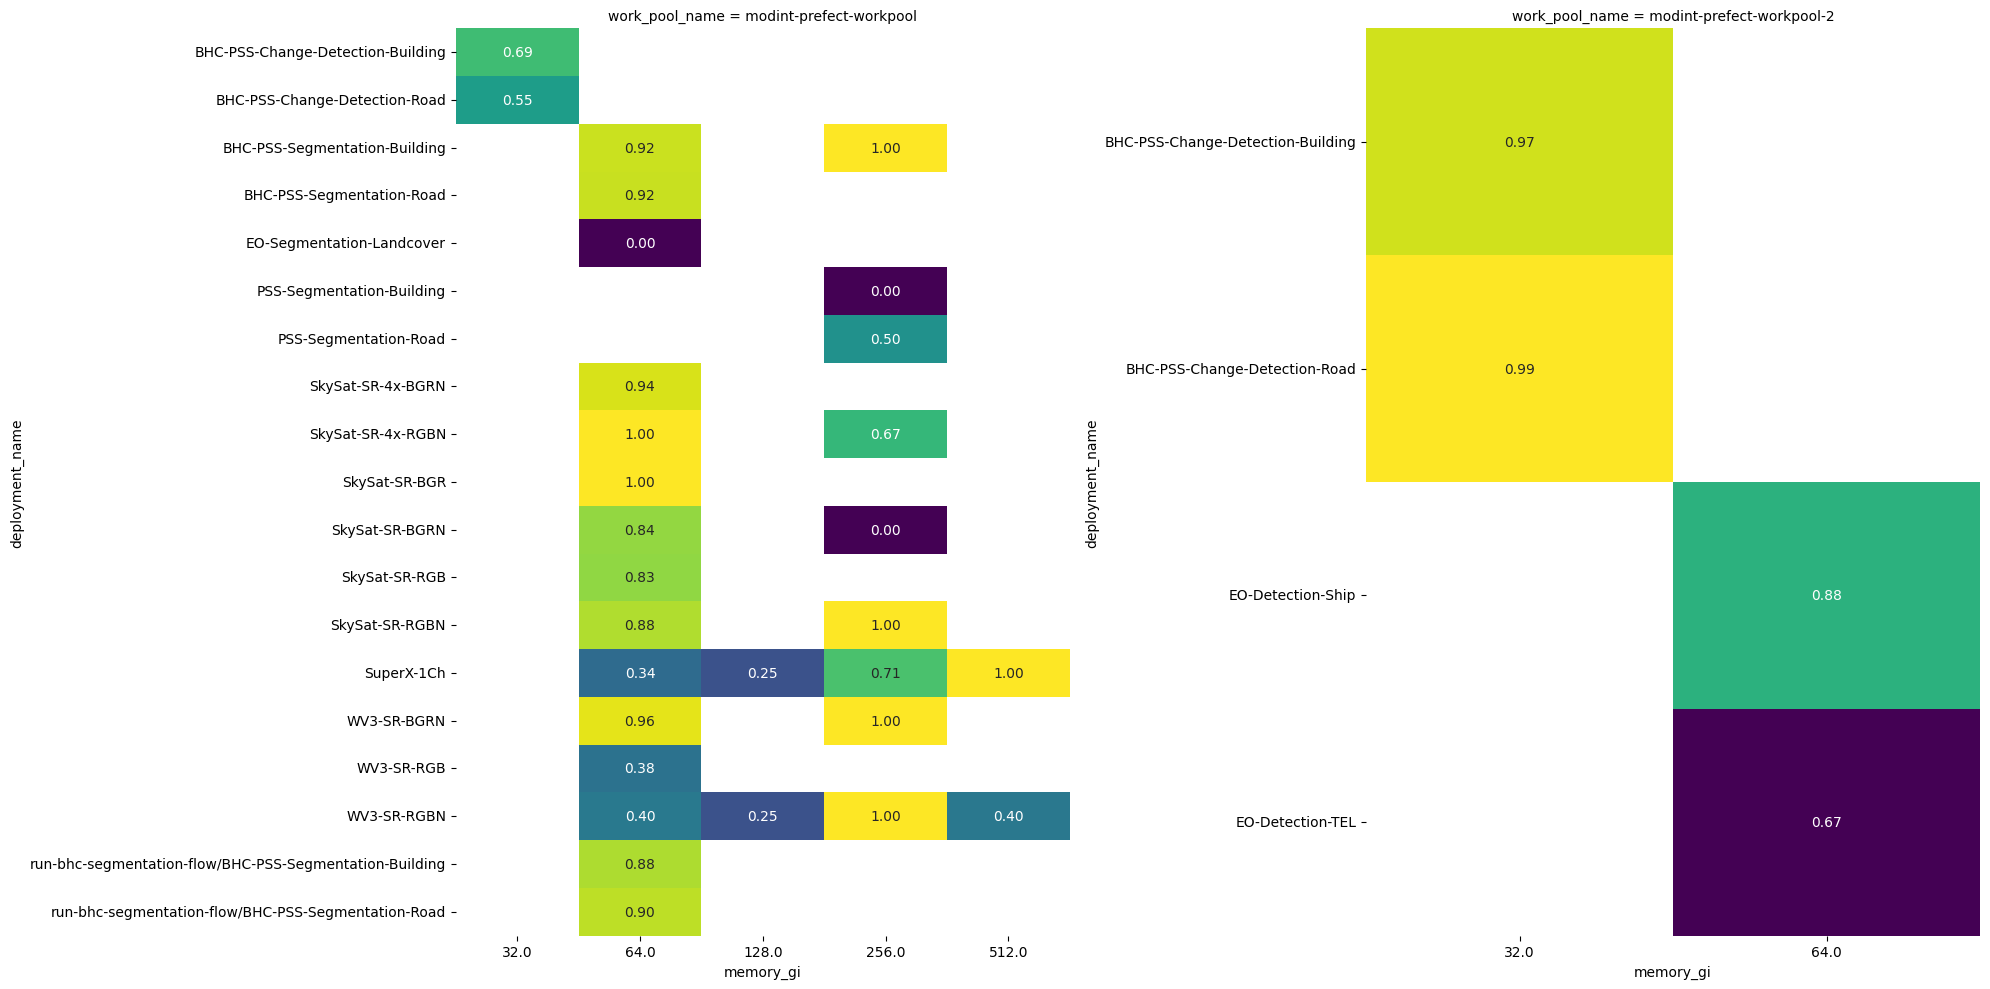

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt

df = rate_area_dep_pool.copy()

g = sns.FacetGrid(
    df,
    col="work_pool_name",
    height=10,
    sharex=False,
    sharey=False
)

def draw(data, **kwargs):
    pivot = data.pivot_table(
        values="success_rate",
        index="deployment_name",
        columns="memory_gi"
    )
    sns.heatmap(pivot, cmap="viridis", annot=True, fmt=".2f", cbar=False)

g.map_dataframe(draw)
plt.show()

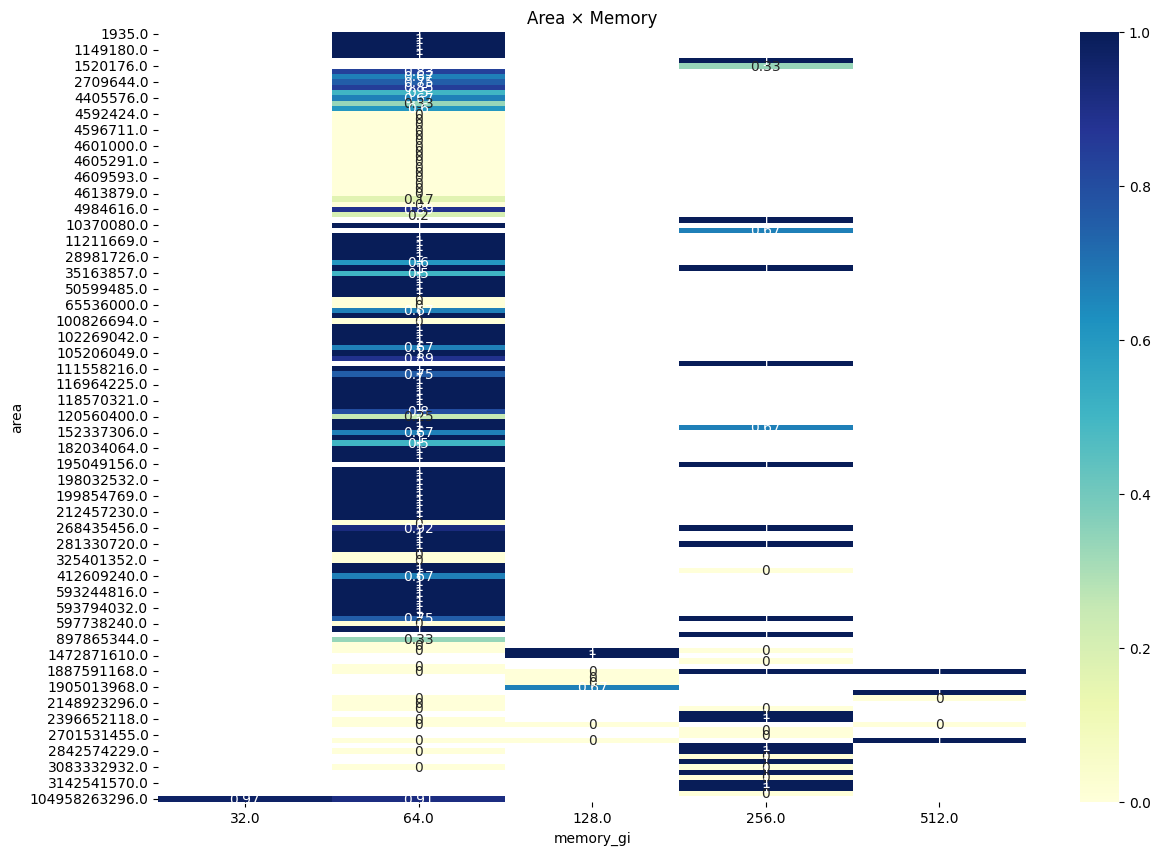

In [94]:
import numpy as np
import seaborn as sns

heat = runs.groupby(["area","memory_gi"])["state_type"] \
           .apply(lambda x: (x=="COMPLETED").mean()) \
           .reset_index().pivot(index="area", columns="memory_gi", values="state_type")

plt.figure(figsize=(14, 10))
sns.heatmap(heat, annot=True, cmap="YlGnBu")
plt.title("Area × Memory")
plt.show()

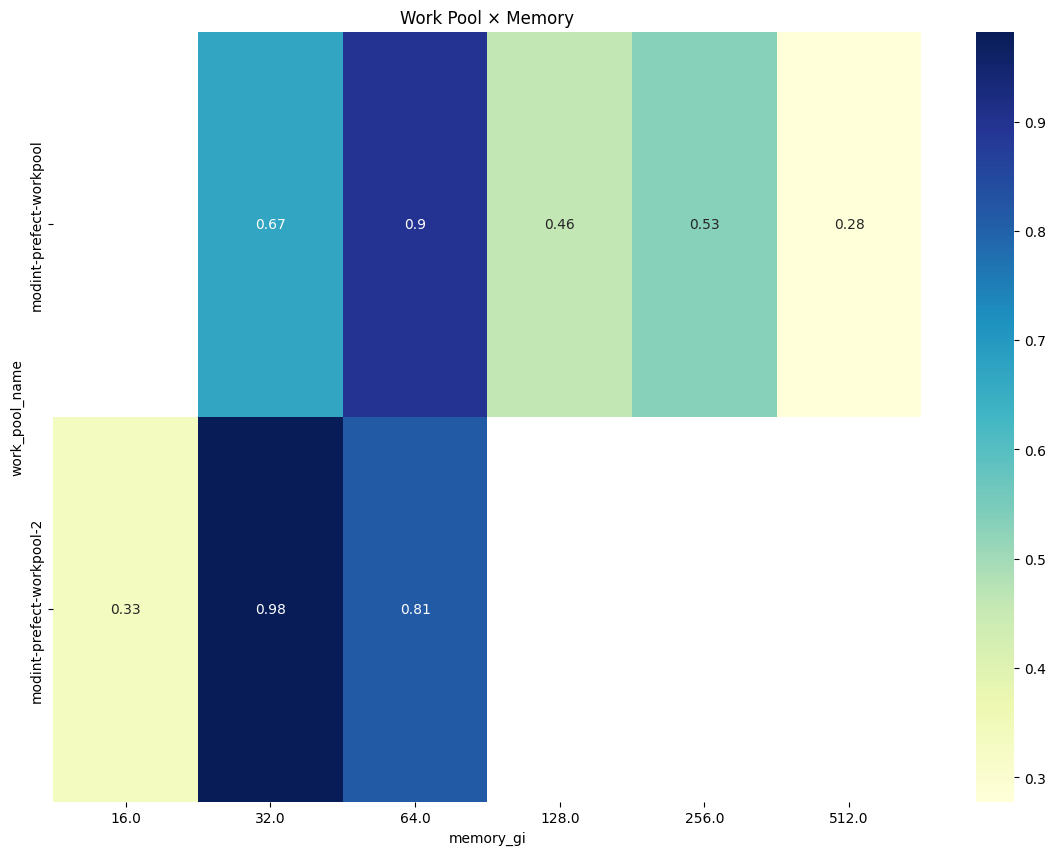

In [95]:
import numpy as np
import seaborn as sns

heat = runs.groupby(["work_pool_name","memory_gi"])["state_type"] \
           .apply(lambda x: (x=="COMPLETED").mean()) \
           .reset_index().pivot(index="work_pool_name", columns="memory_gi", values="state_type")

plt.figure(figsize=(14, 10))
sns.heatmap(heat, annot=True, cmap="YlGnBu")
plt.title("Work Pool × Memory")
plt.show()

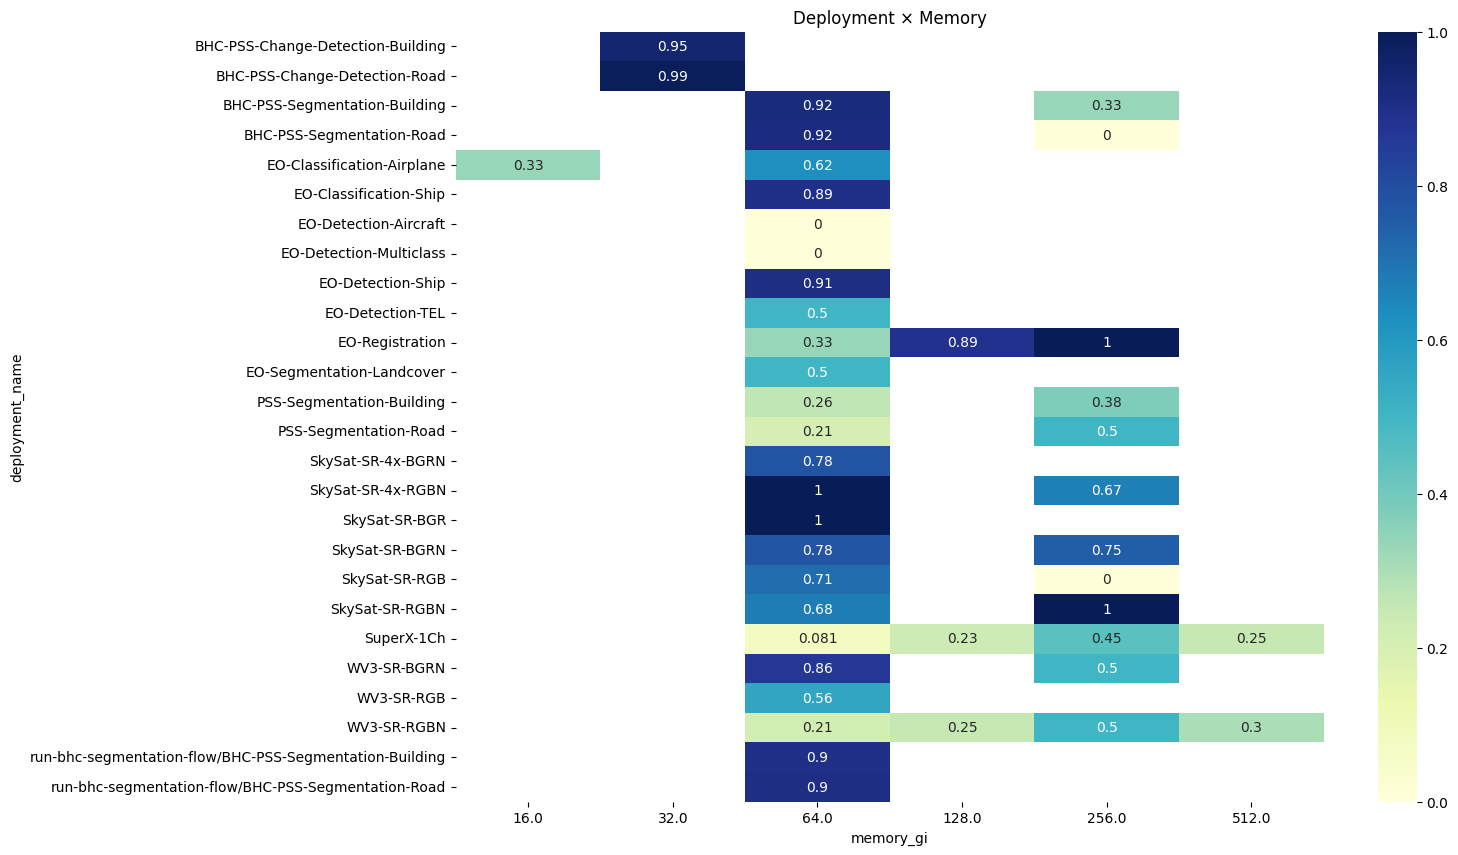

In [96]:
import numpy as np
import seaborn as sns

heat = runs.groupby(["deployment_name","memory_gi"])["state_type"] \
           .apply(lambda x: (x=="COMPLETED").mean()) \
           .reset_index().pivot(index="deployment_name", columns="memory_gi", values="state_type")

plt.figure(figsize=(14, 10))
sns.heatmap(heat, annot=True, cmap="YlGnBu")
plt.title("Deployment × Memory")
plt.show()